What is micrograd? 

Is an Autograd engine (automatic gradient) -> implements backpropagation.

Backpropagation is an algorithm that allows u to efficiently evaluate the gradient (derivative) of some kind of loss function wrt the weights of a NN. This allows us to adjust the weights to minimize the loss.

It will be at the mathematical core of any DL Library.

Its functionality: Micrograd allows us to build mathematical expressions. 

```
from micrograd.engine import Value

# Here, we're building mathematical expression with 2 inputs a & b.
# micrograd wraps these inside Value object

a = Value(-4.0) 
b = Value(2.0)

# we build the math expression where a and b are transformed into c, d then e, f and g

c = a + b # can add 2 value objects
d = a * b + b**3 # multiply, raise to power .. etc

#micrograd builds these math expressions in the background. It knows that c is also a Value object and that it resulted from and addition operation. It also knows the child nodes of c are a & b since it maintains pointers to them. 

c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward() # we can call this and initialize bp at node g. It will start at g and go back through that expression graph and recursively apply the chain rule from calculus. This allows us to calculate the derivative of g wrt all internal nodes and initial a & b

print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db
```

NNs are just mathematical expressions. 

BP doesn't care about NNs. It just deals with arbitrary math expressions. 

micrograd is a scalar-valued autograd engine (works at the level of individual scalars like 4.0 and -2.0). In production, we use Tensors (n-dimensional). These Tensors are filled with scalars but we make operations on them (tensors / large arrays) such it allows us to make use of the parallelism in computers so operations can be done in parallel and make it more efficient.  

micrograd is what u need to train NNs. Everything else is just efficiency. 

Let's build micrograd step by step

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### First: What is a derivative? 

We'll use the numerical definition (not the symbolic manipulation). 

Assuming a function f(x), if we nudge its input x a tiny bit, how will the function respond (+ , 0 , -)? 

$df = \frac{f(x + h) - f(x)} {h}$ 

NB: we normalize through dividing by h to get a slope not an absolute value. 

$f(x + h) - f(x)$ how much the function increased / decreased when bumped by h

$ / h $ normalized through dividing by $h$ to get the slope

In [1]:
def f(x): return 3*x**2 + 4*x + 5

In [2]:
f(3.0)

44.0

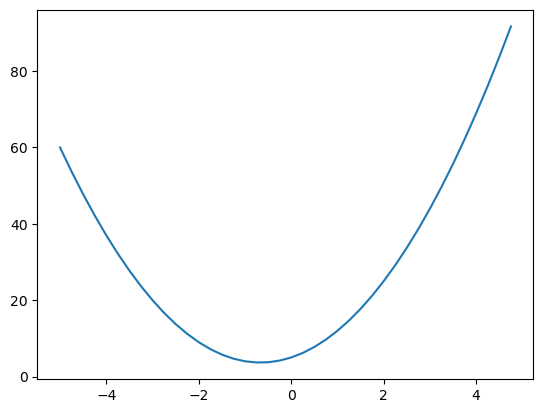

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

In [6]:
h = 0.001
x = 3
(f(x + h) - f(x)) / h

22.002999999997996

Now we'll move to NNs. NNs will be massive mathematical expressions so we need data structures that maintain them. That's what we'll build.

#### Building Value object & forward pass:

We'll start by building the value object. It takes a scalar object and wraps it.

In [9]:
class Value:
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [11]:
a = Value(2.0)
b = Value(-3.0)
a, b

(Value(data=2.0), Value(data=-3.0))

Now we want to be able to add 2 value objects:

In [12]:
class Value:
    def __init__(self, data):
        self.data = data
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    def __repr__(self):
        return f"Value(data={self.data})"

NB: when we use `__add__` , Python will call `a.__add__(b)`

NB: Remeber, since `data` in `self.data = data` is the actual Python number, the result of `a.__add__(b)` will be a number (a floating point) not a Value object (we're not adding objects, we're adding numbers).

In [14]:
a = Value(2.0)
b = Value(-3.0)
a + b

Value(data=-1.0)

Let's implement multiply:

In [17]:
class Value:
    def __init__(self, data):
        self.data = data
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [18]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b

Value(data=-6.0)

In [20]:
d = a*b + c
d

Value(data=4.0)

This is: `(a.__mul(b)).__add__(c)`

Now what we're missing is the connective tissue of this graph. We need to keep track of what values produce other values through pointers.

```
class Value:
    # we introduce an extra input _children as empty tuple by default
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children) # we'll add _prev now as a set to maintan children (andrej doesn't remeber why tuple then set but maybe for efficiency 
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other)) # add children as input
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other)) # add children as input
        return out
    
    def __repr__(self):
        return f"Value(data={self.data})"
```

In [22]:
class Value:
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children) 
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other)) 
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other))
        return out
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [23]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d._prev

{Value(data=-6.0), Value(data=10.0)}

Now, we know what children created each value but we don't know what operation. 

Similar to how we created children, we'll do one more attribute that we'll call `_op`

In [24]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children) 
        self._op = _op
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') 
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [25]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d._op

'+'

Now we know how each expression came to be: from what values and through what operation. 

These expressions are about to get large. We need a way to visualize them.

In [33]:
# for now, just copying this code

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f }" % (n.data, ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

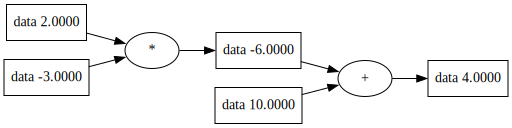

In [34]:
draw_dot(d)

Let's add labels to nodes: 

In [35]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') 
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [50]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(data=4.0)

And modify graphviz to display them:

In [51]:
# for now, just copying this code

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data, ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

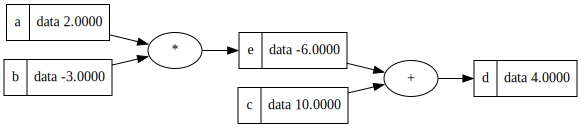

In [52]:
draw_dot(d)

In [53]:
# let's add one more variable to the graph 
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f #output of graph
L.label = 'L'
L

Value(data=-8.0)

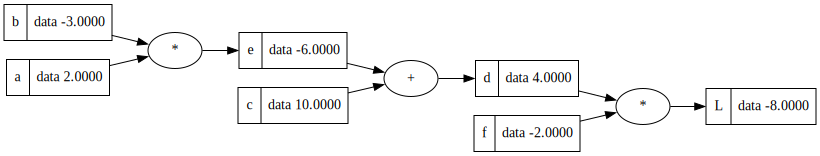

In [54]:
draw_dot(L)

Now, we're able to build this forward pass - mathematical expressions using only + and * for the time. 

What we'd like to do next is to run backpropagation: start at L and compute the gradient for all the intermediate values (wrt L) (these will eventually represent weights of NN). 

#### Building Backpropagation:

The main derivative we want to compute is the derivative of the output (in this case L) w.r.t each node. We'll start by creating an attribute `grad` to store it. We'll also modify `draw_dot` to visualize it:

In [55]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # we're assuming by default no effect of input on output -> 0 derivative
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') 
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [56]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

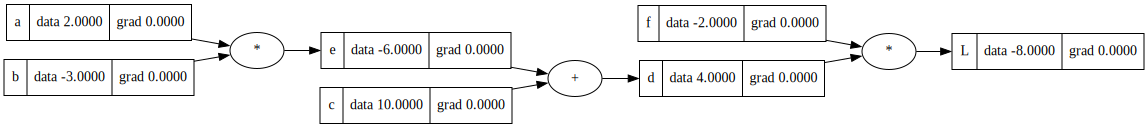

In [57]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f #output of graph
L.label = 'L'
draw_dot(L)

`grad` at each node represents the derivative of the output `L` w.r.t that node eg derivative of `L` wrt `e` or `d` ... etc

Manual Backpropagation:

What is derivative of L wrt L? -> $1.0$

What is derivative of L wrt d? 

We know:

$$ L = d * f $$
$$ dL / dd = f = -2.0$$

Same for L wrt f 
$$ dL / df = d  = 4.0 $$

Now, what is $ dL / de $ ?? 

Remeber, each node only knows about the children that produced it and the operation that did. `L` knows nothing about `e`. d knows about `e`. `d` can compute its drivative wrt `e`. But if we know how `d` changes relative to `e` and how `L` changes relative to `d` then we can find how `L` changes relative to `e`. In short: we multiply.

_From Wikipedia: As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."_



But, what is $ dd / de $? Well, since it's a `+` operation the derivative is 1.0

$$ d = c + e $$

$$ dd / de = 0 + 1.0 = 1.0 $$

or from limit expression: 

$$ dd / de = \frac{f(c + e + h) - f(c + e)}{h} = h/h = 1.0 $$

So, $ dL / de  = dL / dd * dd / de = -2.0 * 1.0 = -2.0 $


And that is all there is to backpropagation. We compute local gradients at each node and recursively apply the chain rule - via multiplication - till the end of the graph. We go on and recursively multiply on the local derivatives. And that's what backpropagation is: recursive application of the chain rule through the computation graph

From this we can manually compute all the gradients for all the nodes in the graph wrt `L`:

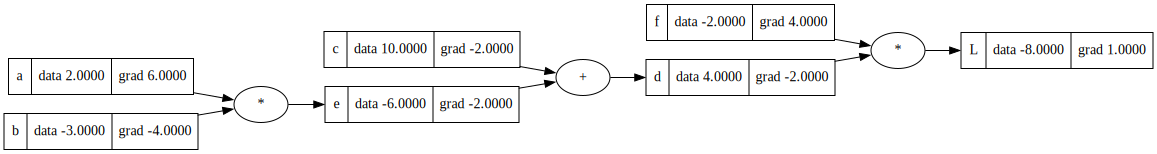

In [66]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f #output of graph
L.label = 'L'

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = 1.0 * -2.0
c.grad = 1.0 * -2.0 
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0
draw_dot(L)

And now we can see this power in action. Suppose now we want to nudge `L` up a bit. What we can do (if we treat a,b,c... as weights) is we can nudge their values in the direction of their gradients (their slopes. Think of them on the graph).

In [67]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad 

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f #output of graph
L.label = 'L'
L

Value(data=-7.286496)

Let's see this in a more complex setting: 

<div>
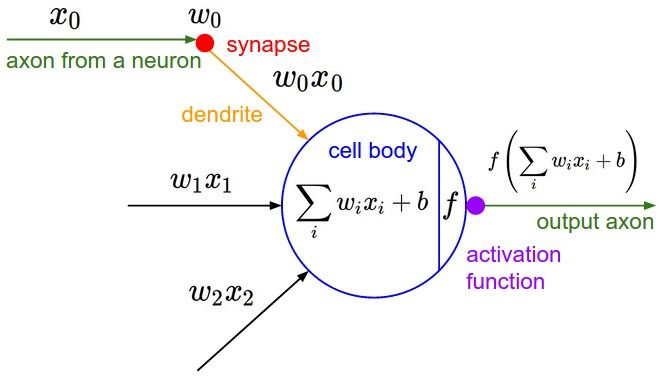
</div>

This is a simplified model of biological neurons. Here, data from other neurons $x_0$. We have synapses that have weights on them $w_0$. The synapse interacts with the input to the neuron multiplicatively so what flows to the cell body of the neuron is $ w * x$. There are multiple inputs. There is also bias that is like the "innate trigger happiness" (can be more or less trigger happy). The neuron takes all inputs (summed) + bias through an activation function $f$ that is usually a squashing function eg $tanh$. 
What comes out is the activation function applied to the dot product of weights and inputs.

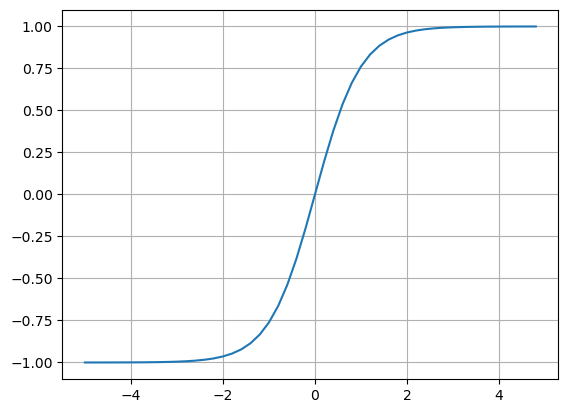

In [72]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

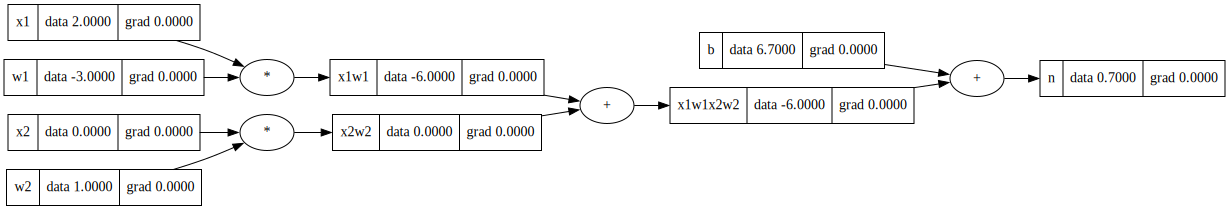

In [74]:
# let's write one out

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the cell body's raw activation 

draw_dot(n)

But in order to produce the final output, our neuron (Value object here) needs to be able to do the $tanh$ function. 
We'll add it to our Value object and it's important to know that we can add any function we want as long as we know how to compute a local derivative for it.

In [77]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') 
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out
    
    def __repr__(self):
        return f"Value(data={self.data})"

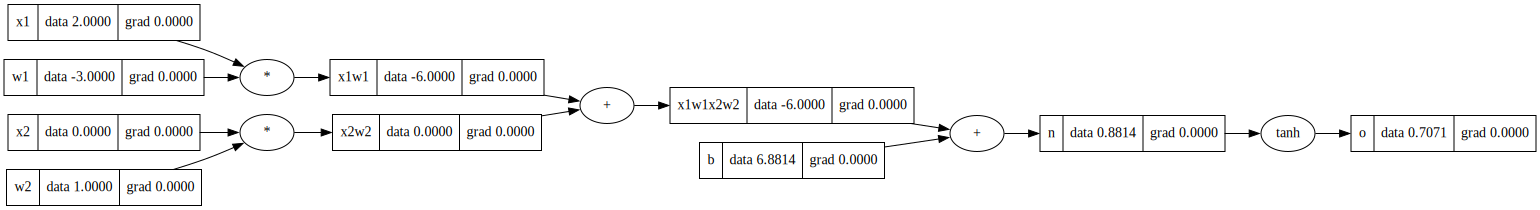

In [82]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b') # this value of b to make numbers nicer for us when we do backprop 

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the cell body's raw activation 
o = n.tanh(); o.label = 'o'
draw_dot(o)